Copyright (c) Microsoft Corporation. All rights reserved.
Licensed under the MIT License.
# Converting the YOLOv4 Model From Darknet or PyTorch Frameworks to ONNX
This notebook provides an overview on how to convert the YOLOv4 model into the ONNX Framework before registering it through the Azure Machine Learning Service. 
## Prerequisites:
* Azure subscription
* Azure Machine Learning Workspace
* Understand the [architecture and terms](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture) introduced by Azure Machine Learning (AML)

The above prerequisites will be used to register the respective models to the Azure ML workspace. If you are simply looking to convert this model to the ONNX Framework, then they can be overlooked. 

If you need further references or examples on converting models from a framework into ONNX (or vice versa), the [ONNX Tutorials Github repo](https://github.com/onnx/tutorials) has proven to be an excellent resource. 

# Table of Contents: 

Throughout the course of this notebook, we show how to convert, register, and conduct inference tests using the YOLOv4 model.

Methodology:
* Install relevant libraries and Github repositories; initialize an AzureML workspace
* Set up pre and post processing 
* Utilize a YOLOv4 model from the ONNX Zoo
* Convert a YOLOv4 model from Darknet to ONNX
* Convert a YOLOv4 model from PyTorch to ONNX

## 1. Install relevent libraries and Github repositories; initialize an AzureML workspace


### 1.1: Installing Relevant Libraries
The following will be required throughout the rest of the notebook; the following code will install them onto whatever system is executing the notebook. If they already exist on said system, nothing will happen.

In [20]:
!pip install azureml-core wget onnx onnxruntime PyYAML pytorch

### 1.2: Retrieving the models from their respective Github repositories

We use wget here to specifically grab the YOLOv4 model from the [ONNX Model Zoo](https://github.com/onnx/models). To work towards inferencing with the baseline model, all we need to do is grab it specifically. There are many ways to do this, but this seemed the most appropriate given the situation. 

In [30]:
import wget
!mkdir onnx
wget.download('https://github.com/onnx/models/raw/master/vision/object_detection_segmentation/yolov4/model/yolov4.tar.gz', './onnx')
!mkdir ./onnx/yolov4
%cd onnx
!tar -xvf ./yolov4.tar.gz ./yolov4

x yolov4/
x yolov4/yolov4.onnx
x yolov4/test_data_set_0/
x yolov4/test_data_set_0/input_0.pb
x yolov4/test_data_set_0/output_2.pb
x yolov4/test_data_set_0/output_0.pb
x yolov4/test_data_set_0/output_1.pb
x yolov4/test_data_set_2/
x yolov4/test_data_set_2/input_0.pb
x yolov4/test_data_set_2/output_2.pb
x yolov4/test_data_set_2/output_0.pb
x yolov4/test_data_set_2/output_1.pb
x yolov4/test_data_set_1/
x yolov4/test_data_set_1/input_0.pb
x yolov4/test_data_set_1/output_2.pb
x yolov4/test_data_set_1/output_0.pb
x yolov4/test_data_set_1/output_1.pb


In [33]:
wget.download('https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names','./')
wget.download('https://raw.githubusercontent.com/onnx/models/master/vision/object_detection_segmentation/yolov4/dependencies/yolov4_anchors.txt','./')

'.//yolov4_anchors.txt'

The [AlexeyAB Github Repository](https://github.com/AlexeyAB/darknet) provides an implementation of the YOLOv4 model in its native Darknet framework. We will also download the yolov4 weights from the Github page.

In [22]:
!git clone https://github.com/AlexeyAB/darknet
%cd darknet/
wget.download('https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights')
%cd ..

The [PyTorch-YOLOv4 Repository](https://github.com/Tianxiaomo/pytorch-YOLOv4) serves to assist in converting models from Darknet or PyTorch into the ONNX Framework. It will also provide the PyTorch model used in this demonstration.

In [21]:
!git clone https://github.com/Tianxiaomo/pytorch-YOLOv4
!cp -r ./pytorch-YOLOv4/tool ./

Cloning into 'pytorch-YOLOv4'...
remote: Enumerating objects: 917, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 917 (delta 0), reused 0 (delta 0), pack-reused 914
Receiving objects: 100% (917/917), 2.34 MiB | 603.00 KiB/s, done.
Resolving deltas: 100% (557/557), done.


### 1.3: Initialize AzureML workspace
To create or access an Azure ML Workspace, you will need to import the Azure ML library and the following information:
- A name for your workspace
- Your subscription id
- The resource group name

Alternatively, you could download the workplace configuration file from Azure ML and initialize the workspace from that. If you choose the latter option, you can skip the following code chunk.

In [ ]:
%%writefile config.json
{
    "subscription_id": "<put your sub_id here>",
    "resource_group": "<put your resource_group here>",
    "workspace_name": "<put your worksapce_name here>",
}

In [ ]:
from azureml.core import Workspace, Model

ws = Workspace.from_config()

## 2. Pre and Post Processing
We need to utilize differing pre and post processing techniques due to the differences in input and output shape and makeup for each of the YOLOv4 models. 

1. The model within the ONNX Zoo has an output shape and makeup that is distinct from the other two. It will have its own pre and post processing method.

2. Fortunately, the Darknet and PyTorch implementations contain the same inputs and outputs, so they can use the same method, which we will refer to as <em> detect</em>.

### Baseline ONNX

In [58]:
%cd onnx

/Users/nickmarangi/Documents/Codework/Python/yolo/yolov4/onnx


In [59]:
import cv2
import numpy as np
from onnx import numpy_helper
import onnx
import os
from PIL import Image
from matplotlib.pyplot import imshow
import onnxruntime as rt
from scipy import special
import colorsys
import random

def image_preprocess(image, target_size, gt_boxes=None):

    ih, iw = target_size
    h, w, _ = image.shape

    scale = min(iw/w, ih/h)
    nw, nh = int(scale * w), int(scale * h)
    image_resized = cv2.resize(image, (nw, nh))

    image_padded = np.full(shape=[ih, iw, 3], fill_value=128.0)
    dw, dh = (iw - nw) // 2, (ih-nh) // 2
    image_padded[dh:nh+dh, dw:nw+dw, :] = image_resized
    image_padded = image_padded / 255.

    if gt_boxes is None:
        return image_padded

    else:
        gt_boxes[:, [0, 2]] = gt_boxes[:, [0, 2]] * scale + dw
        gt_boxes[:, [1, 3]] = gt_boxes[:, [1, 3]] * scale + dh
        return image_padded, gt_boxes

def get_anchors(anchors_path, tiny=False):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    #print(anchors)
    
    anchors = np.array(anchors.split(','), dtype=np.float32)
    return anchors.reshape(3, 3, 2)

def postprocess_bbbox(pred_bbox, ANCHORS, STRIDES, XYSCALE=[1,1,1]):
    '''define anchor boxes'''
    for i, pred in enumerate(pred_bbox):
        conv_shape = pred.shape
        output_size = conv_shape[1]
        conv_raw_dxdy = pred[:, :, :, :, 0:2]
        conv_raw_dwdh = pred[:, :, :, :, 2:4]
        xy_grid = np.meshgrid(np.arange(output_size), np.arange(output_size))
        xy_grid = np.expand_dims(np.stack(xy_grid, axis=-1), axis=2)

        xy_grid = np.tile(np.expand_dims(xy_grid, axis=0), [1, 1, 1, 3, 1])
        xy_grid = xy_grid.astype(np.float)

        pred_xy = ((special.expit(conv_raw_dxdy) * XYSCALE[i]) - 0.5 * (XYSCALE[i] - 1) + xy_grid) * STRIDES[i]
        pred_wh = (np.exp(conv_raw_dwdh) * ANCHORS[i])
        pred[:, :, :, :, 0:4] = np.concatenate([pred_xy, pred_wh], axis=-1)

    pred_bbox = [np.reshape(x, (-1, np.shape(x)[-1])) for x in pred_bbox]
    pred_bbox = np.concatenate(pred_bbox, axis=0)
    return pred_bbox


def postprocess_boxes(pred_bbox, org_img_shape, input_size, score_threshold):
    '''remove boundary boxs with a low detection probability'''
    valid_scale=[0, np.inf]
    pred_bbox = np.array(pred_bbox)

    pred_xywh = pred_bbox[:, 0:4]
    pred_conf = pred_bbox[:, 4]
    pred_prob = pred_bbox[:, 5:]

    # # (1) (x, y, w, h) --> (xmin, ymin, xmax, ymax)
    pred_coor = np.concatenate([pred_xywh[:, :2] - pred_xywh[:, 2:] * 0.5,
                                pred_xywh[:, :2] + pred_xywh[:, 2:] * 0.5], axis=-1)
    # # (2) (xmin, ymin, xmax, ymax) -> (xmin_org, ymin_org, xmax_org, ymax_org)
    org_h, org_w = org_img_shape
    resize_ratio = min(input_size / org_w, input_size / org_h)

    dw = (input_size - resize_ratio * org_w) / 2
    dh = (input_size - resize_ratio * org_h) / 2

    pred_coor[:, 0::2] = 1.0 * (pred_coor[:, 0::2] - dw) / resize_ratio
    pred_coor[:, 1::2] = 1.0 * (pred_coor[:, 1::2] - dh) / resize_ratio

    # # (3) clip some boxes that are out of range
    pred_coor = np.concatenate([np.maximum(pred_coor[:, :2], [0, 0]),
                                np.minimum(pred_coor[:, 2:], [org_w - 1, org_h - 1])], axis=-1)
    invalid_mask = np.logical_or((pred_coor[:, 0] > pred_coor[:, 2]), (pred_coor[:, 1] > pred_coor[:, 3]))
    pred_coor[invalid_mask] = 0

    # # (4) discard some invalid boxes
    bboxes_scale = np.sqrt(np.multiply.reduce(pred_coor[:, 2:4] - pred_coor[:, 0:2], axis=-1))
    scale_mask = np.logical_and((valid_scale[0] < bboxes_scale), (bboxes_scale < valid_scale[1]))

    # # (5) discard some boxes with low scores
    classes = np.argmax(pred_prob, axis=-1)
    scores = pred_conf * pred_prob[np.arange(len(pred_coor)), classes]
    score_mask = scores > score_threshold
    mask = np.logical_and(scale_mask, score_mask)
    coors, scores, classes = pred_coor[mask], scores[mask], classes[mask]

    return np.concatenate([coors, scores[:, np.newaxis], classes[:, np.newaxis]], axis=-1)

def bboxes_iou(boxes1, boxes2):
    '''calculate the Intersection Over Union value'''
    boxes1 = np.array(boxes1)
    boxes2 = np.array(boxes2)

    boxes1_area = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
    boxes2_area = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])

    left_up       = np.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down    = np.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = np.maximum(right_down - left_up, 0.0)
    inter_area    = inter_section[..., 0] * inter_section[..., 1]
    union_area    = boxes1_area + boxes2_area - inter_area
    ious          = np.maximum(1.0 * inter_area / union_area, np.finfo(np.float32).eps)

    return ious

def nms(bboxes, iou_threshold, sigma=0.3, method='nms'):
    """
    :param bboxes: (xmin, ymin, xmax, ymax, score, class)

    Note: soft-nms, https://arxiv.org/pdf/1704.04503.pdf
          https://github.com/bharatsingh430/soft-nms
    """
    classes_in_img = list(set(bboxes[:, 5]))
    best_bboxes = []

    for cls in classes_in_img:
        cls_mask = (bboxes[:, 5] == cls)
        cls_bboxes = bboxes[cls_mask]

        while len(cls_bboxes) > 0:
            max_ind = np.argmax(cls_bboxes[:, 4])
            best_bbox = cls_bboxes[max_ind]
            best_bboxes.append(best_bbox)
            cls_bboxes = np.concatenate([cls_bboxes[: max_ind], cls_bboxes[max_ind + 1:]])
            iou = bboxes_iou(best_bbox[np.newaxis, :4], cls_bboxes[:, :4])
            weight = np.ones((len(iou),), dtype=np.float32)

            assert method in ['nms', 'soft-nms']

            if method == 'nms':
                iou_mask = iou > iou_threshold
                weight[iou_mask] = 0.0

            if method == 'soft-nms':
                weight = np.exp(-(1.0 * iou ** 2 / sigma))

            cls_bboxes[:, 4] = cls_bboxes[:, 4] * weight
            score_mask = cls_bboxes[:, 4] > 0.
            cls_bboxes = cls_bboxes[score_mask]

    return best_bboxes

def read_class_names(class_file_name):
    '''loads class name from a file'''
    names = {}
    with open(class_file_name, 'r') as data:
        for ID, name in enumerate(data):
            names[ID] = name.strip('\n')
    return names

def draw_bbox(image, bboxes, classes=read_class_names("coco.names"), show_label=True):
    """
    bboxes: [x_min, y_min, x_max, y_max, probability, cls_id] format coordinates.
    """

    num_classes = len(classes)
    image_h, image_w, _ = image.shape
    hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

    random.seed(0)
    random.shuffle(colors)
    random.seed(None)

    for i, bbox in enumerate(bboxes):
        coor = np.array(bbox[:4], dtype=np.int32)
        fontScale = 0.5
        score = bbox[4]
        class_ind = int(bbox[5])
        bbox_color = colors[class_ind]
        bbox_thick = int(0.6 * (image_h + image_w) / 600)
        c1, c2 = (coor[0], coor[1]), (coor[2], coor[3])
        cv2.rectangle(image, c1, c2, bbox_color, bbox_thick)

        if show_label:
            bbox_mess = '%s: %.2f' % (classes[class_ind], score)
            t_size = cv2.getTextSize(bbox_mess, 0, fontScale, thickness=bbox_thick//2)[0]
            cv2.rectangle(image, c1, (c1[0] + t_size[0], c1[1] - t_size[1] - 3), bbox_color, -1)
            cv2.putText(image, bbox_mess, (c1[0], c1[1]-2), cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale, (0, 0, 0), bbox_thick//2, lineType=cv2.LINE_AA)

    return image

In [60]:
%cd ..

/Users/nickmarangi/Documents/Codework/Python/yolo/yolov4


### PyTorch-ONNX and Darknet-ONNX

In [98]:
import sys
import onnx
import os
import argparse
import numpy as np
import cv2
import onnxruntime

from tool.utils import *
from tool.darknet2onnx import *

def detect(session, image_src):
    IN_IMAGE_H = session.get_inputs()[0].shape[2]
    IN_IMAGE_W = session.get_inputs()[0].shape[3]


    print("ONNX Representation of Inputs: ", session.get_inputs()[0].shape)
    print("ONNX Representation of Height and Width: ", IN_IMAGE_H, IN_IMAGE_W)

    # Input
    resized = cv2.resize(image_src, (IN_IMAGE_W, IN_IMAGE_H), interpolation=cv2.INTER_CUBIC)
    img_in = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
    img_in = np.transpose(img_in, (2, 0, 1)).astype(np.float32)
    img_in = np.expand_dims(img_in, axis=0)
    img_in /= 255.0
    print("Shape of the network input: ", img_in.shape)

    # Compute
    input_name = session.get_inputs()[0].name


    outputs = session.run(None, {input_name: img_in})

    print("Shape of the network outputs: ", outputs[0].shape, " ", outputs[1].shape)

    # print(np.max(outputs[1], axis = 2))
    # print(np.max(outputs[1], axis = 2)[0] > 0.4)
    # print(outputs[0, np.max(outputs[1], axis = 2)[0] > 0.4,:])

    boxes = post_processing(img_in, 0.4, 0.6, outputs)

    num_classes = 80
    if num_classes == 20:
        namesfile = './darknet/data/voc.names'
    elif num_classes == 80:
        namesfile = './darknet/data/coco.names'
    else:
        namesfile = 'data/names'

    class_names = load_class_names(namesfile)
    plot_boxes_cv2(image_src, boxes[0], savename='predictions_onnx.jpg', class_names=class_names)
    return outputs

## 2. Utilize a YOLOv4 model from the ONNX Zoo
In this section, we look to provide a short introduction where we run an inference session with an ONNX model before registering it in AML. You will notice that we override an input name and data type in the session options; here we are inputting the batch size for the model.

In [95]:
import onnxruntime
from PIL import Image

input_size = 416

original_image = cv2.imread("./Eiger.png")
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
original_image_size = original_image.shape[:2]

image_data = image_preprocess(np.copy(original_image), [input_size, input_size])
image_data = image_data[np.newaxis, ...].astype(np.float32)

print("Shape of the network input: ", image_data.shape)


sess = onnxruntime.InferenceSession('./onnx/yolov4/yolov4.onnx')

# input
IN_IMAGE_H = sess.get_inputs()[0].shape[1]
IN_IMAGE_W = sess.get_inputs()[0].shape[2]

print("ONNX Representation of Inputs: ", sess.get_inputs()[0].shape)
print("ONNX Representation of Height and Width: ", IN_IMAGE_H, IN_IMAGE_W)

outputs = sess.get_outputs()
output_names = list(map(lambda output: output.name, outputs))
input_name = sess.get_inputs()[0].name

detections = sess.run(output_names, {input_name: image_data.astype(np.float32)})
print("Output shape:", list(map(lambda detection: detection.shape, detections)))

ANCHORS = "./onnx/yolov4_anchors.txt"
STRIDES = [8, 16, 32]
XYSCALE = [1.2, 1.1, 1.05]

ANCHORS = get_anchors(ANCHORS)
STRIDES = np.array(STRIDES)

pred_bbox = postprocess_bbbox(detections, ANCHORS, STRIDES, XYSCALE)
bboxes = postprocess_boxes(pred_bbox, original_image_size, input_size, 0.25)
bboxes = nms(bboxes, 0.213, method='nms')
image = draw_bbox(original_image, bboxes)

Shape of the network input:  (1, 416, 416, 3)
ONNX Representation of Inputs:  ['unk__2104', 416, 416, 3]
ONNX Representation of Height and Width:  416 416
Output shape: [(1, 52, 52, 3, 85), (1, 26, 26, 3, 85), (1, 13, 13, 3, 85)]


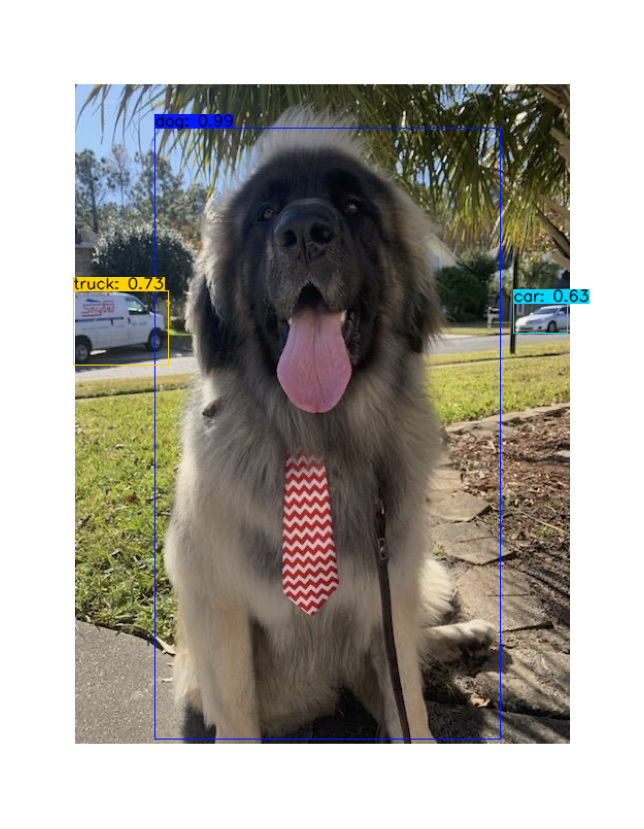

In [97]:
plt.figure(figsize = (15,15))
plt.imshow(image)
plt.axis('off')
plt.savefig('./eigs3.png')

Finally, we register the model in Azure ML

In [ ]:
model = Model.register(
    model_path=model_path,
    model_name="yolov4_onnx",
    description="Tutorial of Running and Registering ONNX Model",
    workspace=ws,
    model_framework=Model.Framework.ONNX,
    model_framework_version=1.6
)

## Converting yolov4 from Darknet to ONNX
When working with this implementation, you will need to:

`1.`: Open the cfg file `yolov4.cfg` (that describes the model layers themselves) to convert the width and height to 416 rather than 608. 

`2.`: Additionally, there is a line of code in the `darknet2pytorch.py` file that should (optionally) be removed: "convalution haven't activate linear" is printed whenever the file is run. It means nothing. 

The below file will convert the model, layer by layer, from the Darknet framework into PyTorch, and then from PyTorch into the ONNX framework. 

In [74]:
%cd pytorch-YOLOv4/
from tool.darknet2onnx import transform_to_onnx
transform_to_onnx('../darknet/cfg/yolov4.cfg','../darknet/yolov4.weights', -1)

/Users/nickmarangi/Documents/Codework/Python/yolo/yolov4/pytorch-YOLOv4
convalution havn't activate linear
convalution havn't activate linear
convalution havn't activate linear
layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32
    1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64
    2 conv     64  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  64
    3 route  1
    4 conv     64  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  64
    5 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32
    6 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64
    7 shortcut 4
    8 conv     64  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  64
    9 route  8 2
   10 conv     64  1 x 1 / 1   208 x 208 x 128   ->   208 x 208 x  64
   11 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128
   12 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
   13 r

In [75]:
!mv ./yolov4_-1_3_416_416_dynamic.onnx ../darknet/
%cd ..

/Users/nickmarangi/Documents/Codework/Python/yolo/yolov4/pytorch-YOLOv4


After successfully converting the model and moving it to the darknet folder, we run it through an inference session to ensure it works, and can finally register it via Azure ML

In [77]:
model_path = './darknet/yolov4_-1_3_416_416_dynamic.onnx'
sessiono = onnxruntime.SessionOptions()

sessiono.add_free_dimension_override_by_name('batch_size', 1)

session = onnxruntime.InferenceSession(model_path, sess_options=sessiono)
img_test = cv2.imread('./Eiger.png')
detect(session, img_test)

ONNX Representation of Inputs:  [1, 3, 416, 416]
ONNX Representation of Height and Width:  416 416
Shape of the network input:  (1, 3, 416, 416)
Shape of the network outputs:  (1, 10647, 1, 4)   (1, 10647, 80)
-----------------------------------
       max and argmax : 0.001749
                  nms : 0.000978
Post processing total : 0.002727
-----------------------------------
car: 0.883748
truck: 0.804702
dog: 0.978920
tie: 0.896446
save plot results to predictions_onnx.jpg


[array([[[[-3.1860359e-04, -6.3193040e-03,  2.6579155e-02,
            3.2882214e-02]],
 
         [[-1.6859174e-04, -5.6110481e-03,  6.1557181e-02,
            3.4799643e-02]],
 
         [[ 3.5917573e-03, -3.2589566e-03,  8.6295903e-02,
            2.8331948e-02]],
 
         ...,
 
         [[ 5.5623955e-01,  7.3318958e-01,  1.0522690e+00,
            1.1782205e+00]],
 
         [[ 6.2123436e-01,  7.5237578e-01,  1.1412299e+00,
            1.1794763e+00]],
 
         [[ 6.9743556e-01,  6.8633282e-01,  1.2479315e+00,
            1.2414541e+00]]]], dtype=float32),
 array([[[1.61180233e-05, 8.30297431e-09, 1.30800629e-07, ...,
          1.38845095e-08, 6.66024036e-09, 1.57646056e-07],
         [1.20552995e-05, 2.38897080e-09, 1.62558695e-08, ...,
          2.99979863e-09, 2.12330598e-09, 9.17952470e-09],
         [6.45586533e-06, 2.52994159e-09, 1.08692868e-08, ...,
          2.29569430e-09, 7.92046428e-10, 1.54936330e-09],
         ...,
         [4.77334172e-09, 4.94031482e-11, 1.3586

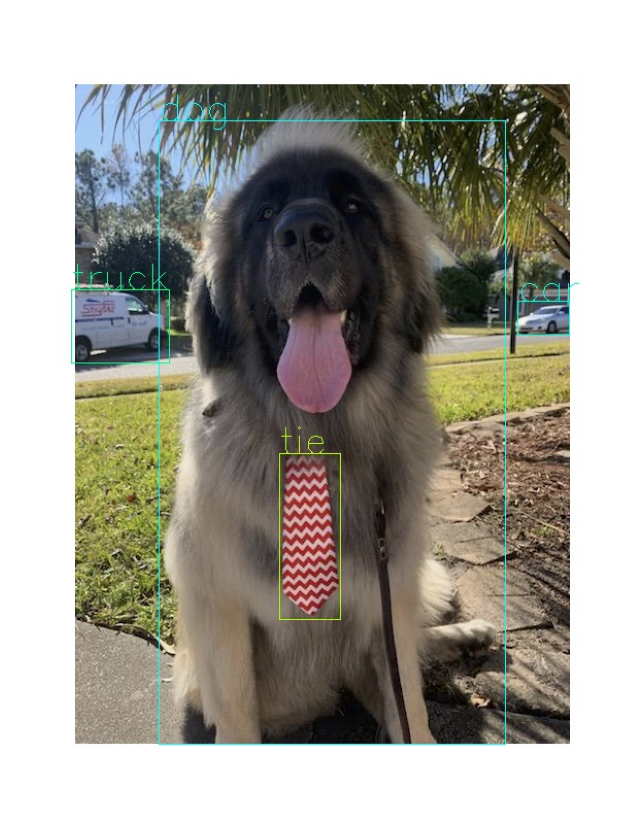

<Figure size 432x288 with 0 Axes>

In [91]:
image = cv2.imread('./predictions_onnx.jpg')
image = image[:,:,::-1] 
plt.figure(figsize = (15,15))
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
model = Model.register(
    model_path=model_path,
    model_name="yolov4_darknet_onnx",
    description="Tutorial on converting from Darknet to ONNX",
    workspace=ws,
    model_framework=Model.Framework.ONNX,
    model_framework_version=1.6
)

## Converting a model from Pytorch to ONNX

[Tianxiaomo's pytorch-YOLOv4 Github Repository](https://github.com/Tianxiaomo/pytorch-YOLOv4) serves to assist in converting models from the Darknet framework to either PyTorch or ONNX. Their repo also provides a link to the weights for a PyTorch implementation of YOLOv4. After downloading the weights from their respective drive, we will convert the model into the ONNX framework.

In [61]:
import gdown
url = 'https://drive.google.com/uc?id=1wv_LiFeCRYwtpkqREPeI13-gPELBDwuJ'
output = 'torch_to_onnx.pth'
gdown.download(url, output)

Downloading...
From: https://drive.google.com/uc?id=1wv_LiFeCRYwtpkqREPeI13-gPELBDwuJ
To: /Users/nickmarangi/Documents/Codework/Python/yolo/yolov4/pytorch-YOLOv4/torch_to_onnx.pth
258MB [00:26, 9.74MB/s]


'torch_to_onnx.pth'

In [81]:
%cd pytorch-YOLOv4
!python demo_pytorch2onnx.py ./torch_to_onnx.pth ../Eiger.png -1 80 416 416

/Users/nickmarangi/Documents/Codework/Python/yolo/yolov4/pytorch-YOLOv4
Converting to onnx and running demo ...
Export the onnx model ...
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/function_base.py:113: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  num = operator.index(num)
/Users/nickmarangi/Documents/Codework/Python/yolo/yolov4/pytorch-YOLOv4/tool/yolo_layer.py:227: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  bx = bxy[:, ii : ii + 1] + torch.tensor(grid_x, device=device, dtype=torch.float32) # grid_x.t

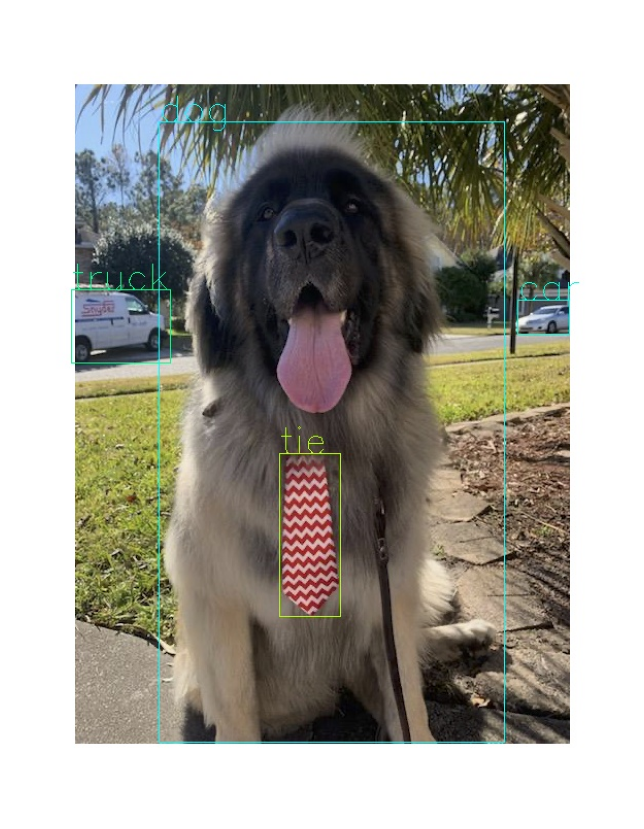

<Figure size 432x288 with 0 Axes>

In [86]:
image = cv2.imread('./predictions_onnx.jpg')
image = image[:,:,::-1] 
plt.figure(figsize = (15,15))
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
%cd ..

In [65]:
model = './pytorch-YOLOv4/yolov4_-1_3_416_416_dynamic.onnx'
sessiono = onnxruntime.SessionOptions()

sessiono.add_free_dimension_override_by_name('batch_size', 1)

session = onnxruntime.InferenceSession(model, sess_options=sessiono)
img_test = cv2.imread('./Eiger.png')
detect(session, img_test)

ONNX Representation of Inputs:  [1, 3, 416, 416]
ONNX Representation of Height and Width:  416 416
Shape of the network input:  (1, 3, 416, 416)
Shape of the network outputs:  (1, 10647, 1, 4)   (1, 10647, 80)
-----------------------------------
       max and argmax : 0.001977
                  nms : 0.001714
Post processing total : 0.003691
-----------------------------------
car: 0.883748
truck: 0.804702
dog: 0.978920
tie: 0.896446
save plot results to predictions_onnx.jpg


[array([[[[-0.00090442,  -0.0069303,    0.025993,    0.032271]],
 
         [[-0.00047662,  -0.0064409,    0.061249,     0.03397]],
 
         [[  0.0041139,  -0.0037458,    0.086818,    0.027845]],
 
         ...,
 
         [[     0.5564,     0.73347,      1.0524,      1.1785]],
 
         [[     0.6214,     0.75217,      1.1414,      1.1793]],
 
         [[     0.6969,     0.68622,      1.2474,      1.2413]]]], dtype=float32),
 array([[[ 1.6118e-05,   8.303e-09,   1.308e-07, ...,  1.3885e-08,  6.6602e-09,  1.5765e-07],
         [ 1.2055e-05,   2.389e-09,  1.6256e-08, ...,  2.9998e-09,  2.1233e-09,  9.1795e-09],
         [ 6.4559e-06,  2.5299e-09,  1.0869e-08, ...,  2.2957e-09,  7.9205e-10,  1.5494e-09],
         ...,
         [ 4.7733e-09,  4.9403e-11,  1.3587e-09, ...,  4.6076e-10,  6.5246e-11,  2.0726e-10],
         [          0,           0,           0, ...,           0,           0,           0],
         [ 2.8293e-08,   5.862e-13,  7.0973e-11, ...,   1.011e-09,  5.3152e-11,  5

In [ ]:
model = Model.register(
    model_path=model_path,
    model_name="yolov4_pytorch_onnx",
    description="Tutorial on converting from PyTorch to ONNX",
    workspace=ws,
    model_framework=Model.Framework.ONNX,
    model_framework_version=1.6
)